<a href="https://colab.research.google.com/github/tmtakashi/signal_processing/blob/master/lms_system_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 音響環境制御特論課題1

#### 1) ピンクノイズを生じるFIRフィルタを求めよ。タップ数は4096, サンプリング周波数は48000Hzとする。振幅特性と位相特性を決めて、折返しを考慮して逆FFTを用いて算出すること。

In [0]:
import numpy as np
import matplotlib.pyplot as plt

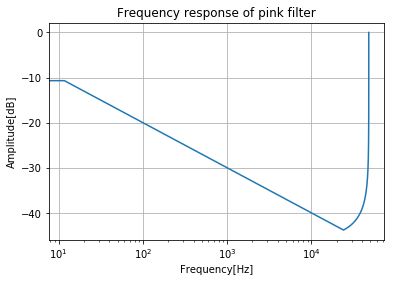

In [0]:
fs = 48000
N = 4096
I = 128

f = np.arange(0, fs, fs/N)
a_pink = np.r_[np.ones([1]), 1./np.sqrt(f[1:])]

a_pink = np.r_[a_pink[:len(a_pink)//2], np.flip(a_pink[:len(a_pink)//2])] # 折返し成分の付加

plt.plot(f, 20*np.log10(a_pink))
plt.title("Frequency response of pink filter")
plt.xscale('log')
plt.xlabel('Frequency[Hz]')
plt.ylabel('Amplitude[dB]')
plt.grid()
plt.show()

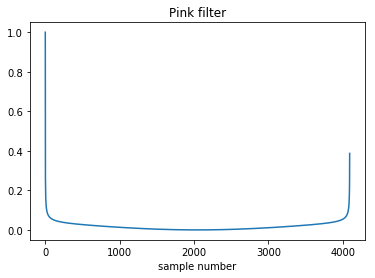

In [0]:
pink_filter = np.real(np.fft.ifft(a_pink))
pink_filter = pink_filter / np.max(pink_filter)

plt.plot(pink_filter)
plt.xlabel('sample number')
plt.title('Pink filter')
plt.show()

#### 2)ホワイトノイズをそのフィルタに通して、ピンクノイズになっていることを確認すること。

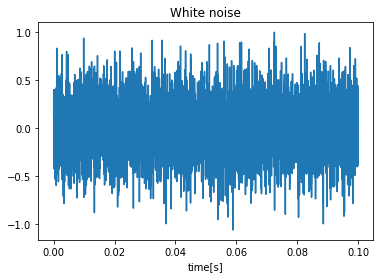

In [0]:
# ホワイトノイズを発生させる
duration = 0.1
t = np.linspace(0, duration, int(duration * fs))
wn = np.random.randn(int(fs * duration))
wn = wn / np.max(wn)

plt.plot(t, wn)
plt.xlabel('time[s]')
plt.title('White noise')
plt.show()

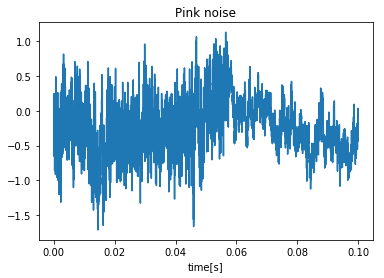

In [0]:
#  フィルタと畳み込んでピンクノイズ生成
pn = np.convolve(wn, pink_filter, mode='same') 
t = np.linspace(0, len(pn)/fs, len(pn))

plt.plot(t, pn)
plt.xlabel('time[s]')
plt.title('Pink noise')
plt.show()

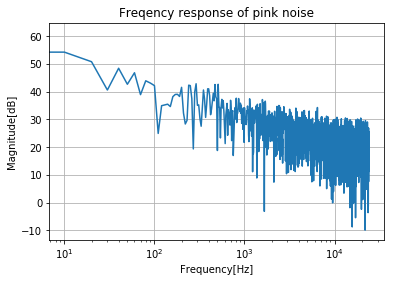

In [0]:
# 生成したピンクノイズの周波数特性の確認
pn_freq = np.fft.fft(pn)
f_axis = np.linspace(0, fs/2, len(pn_freq)//2)

plt.plot(f_axis, 20*np.log10(np.abs(pn_freq))[:len(pn_freq)//2])
plt.title('Freqency response of pink noise')
plt.xscale('log')
plt.xlabel('Frequency[Hz]')
plt.ylabel('Magnitude[dB]')
plt.grid()
plt.show()

ほぼ$-10\mathrm{db/decade}$となっているのでピンクノイズが生成できていると言える。

#### 3)このフィルタを用いて自己相関行列$\mathbf{A}$と相互相関ベクトル$\mathbf{b}$がどのように表されるか示せ。

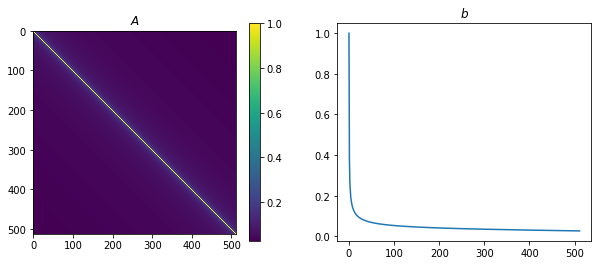

In [0]:
from scipy.linalg import toeplitz

# 相互（自己）相関ベクトル
b_pink = pink_filter[:I]

# 自己相関行列
A_pink= toeplitz(pink_filter[:I])

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('$A$')
img = plt.imshow(A_pink, interpolation='nearest')
plt.colorbar(img)

plt.subplot(1, 2, 2)
plt.title('$b$')
plt.plot(b_pink)

plt.show()

#### 4)これらの情報から、コスト関数の最小値$J_{min}$を求めよ。

In [0]:
from scipy.linalg import solve_toeplitz

c_pink = pink_filter[0] ** 2

Jmin_pink = c_pink - b_pink.T.dot(solve_toeplitz(pink_filter[:I], b_pink))
print("コスト関数の最小値J_min: ", Jmin_pink)

コスト関数の最小値J_min:  0.0


#### 5)遅延が生じた場合の自己相関行列、相互相関ベクトルがどのように表されるか示せ。

遅延が$\Delta$サンプル生じたときの相互相関関数を$R^{\Delta}_{xd}(m)$とすると、

$$
\begin{eqnarray}
R^{\Delta}_{xd}(m) &=& \sum_{i=0}^{I-1}x(i-\Delta)d(i+m) \\
                                   &=& \sum_{i=0}^{I-1}x(i-\Delta - m)d(i) \\
                                   &=& \sum_{i=0}^{I-1}x(i-(m + \Delta))d(i) \\
                                   &=& R_{xd}(m+\Delta)
\end{eqnarray}
$$

同様に遅延が生じた場合の自己相関関数$R^{\Delta}_{xx}(m)$は

$$
R^{\Delta}_{xx}(m) = R_{xx}(m+\Delta)
$$

したがって、この場合の相互相関ベクトル$\mathbf{b}^\Delta$は

$$
\begin{eqnarray}
\mathbf{b}^\Delta &=& [R^{\Delta}_{xx}(0), R^{\Delta}_{xx}(1), \dots, R^{\Delta}_{xx}(I-1)]^\mathsf{T} \\
                                 &=& [R_{xx}(\Delta), R_{xx}(\Delta + 1), \dots, R_{xx}(I-1 +\Delta)]^\mathsf{T}
\end{eqnarray}
$$

自己相関行列$A^\Delta$は
$$
\begin{eqnarray}
\mathbf{A}^\Delta 
&=& 
\begin{bmatrix}
R^{\Delta}_{xx}(0) & R^{\Delta}_{xx}(1) & \dots & R^{\Delta}_{xx}(I-1) \\
R^{\Delta}_{xx}(1) & R^{\Delta}_{xx}(0) &  &  \\
\vdots &  & \ddots &  \\
R^{\Delta}_{xx}(I -1) &  & \dots &  R^{\Delta}_{xx}(0)\\
\end{bmatrix}
\\
&=&
\begin{bmatrix}
R_{xx}(\Delta) & R_{xx}(\Delta + 1) & \dots & R_{xx}(I-1 + \Delta) \\
R_{xx}(\Delta + 1) & R_{xx}(\Delta) &  &  \\
\vdots &  & \ddots &  \\
R_{xx}(I - 1 -\Delta) &  & \dots &  R_{xx}(\Delta)\\
\end{bmatrix}
\end{eqnarray}
$$
となる。

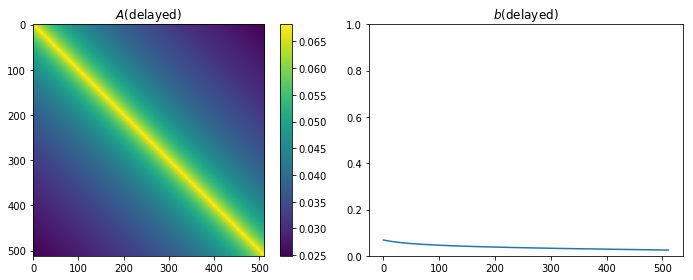

In [0]:
delta = 50

# 相互（自己）相関ベクトル
b_pink_delay = pink_filter[delta:I+delta]

# 自己相関行列
A_pink_delay = toeplitz(pink_filter[delta:I+delta])

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('$A$(delayed)')
img = plt.imshow(A_pink_delay, interpolation='nearest')
plt.colorbar(img)

plt.subplot(1, 2, 2)
plt.title('$b$(delayed)')
plt.plot(b_pink_delay)
plt.ylim(0, 1)


plt.tight_layout()
plt.show()

#### 6) 結果的に, Fig. 2.7のような減衰量が得られることを示せ。

まずはブラウンフィルタを作成する。

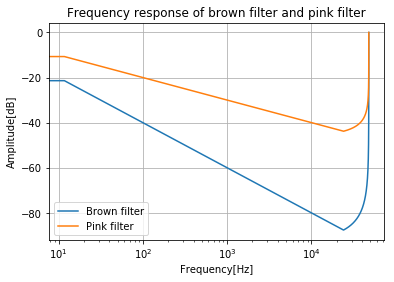

In [0]:
# ブラウンノイズの生成
f = np.arange(0, fs, fs/N)
a_brown = np.r_[np.array([1]), 1./f[1:]]

a_brown = np.r_[a_brown[:len(a_brown)//2], np.flip(a_brown[:len(a_brown)//2])] # 折返し成分の付加

plt.plot(f, 20*np.log10(a_brown), label="Brown filter")
plt.plot(f, 20*np.log10(a_pink), label="Pink filter")
plt.title("Frequency response of brown filter and pink filter")
plt.xscale('log')
plt.xlabel('Frequency[Hz]')
plt.ylabel('Amplitude[dB]')
plt.grid()
plt.legend()
plt.show()

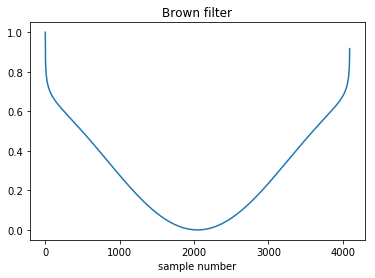

In [0]:
brown_filter = np.real(np.fft.ifft(a_brown))
brown_filter = brown_filter / np.max(brown_filter) # 正規化

plt.plot(brown_filter)
plt.xlabel('sample number')
plt.title('Brown filter')
plt.show()

ブラウンフィルタを用いた場合のコスト関数の最小値

In [0]:
A_brown = toeplitz(brown_filter[:I]) # ブラウンフィルタの自己相関行列（遅延がない場合）
b_brown = brown_filter[:I] # ブラウンフィルタの相互相関ベクトル（遅延がない場合）　　　　　　　　

In [0]:
delta_max = 100
J_pink = np.zeros(delta_max + 1)
J_brown = np.zeros(delta_max + 1)
c_pink = pink_filter[0] ** 2
c_brown = brown_filter[0] ** 2

Jmin_pink = c_pink - b_pink.T.dot(solve_toeplitz(pink_filter[:I], b_pink))
Jmin_brown = c_brown - b_brown.T.dot(solve_toeplitz(brown_filter[:I], b_brown))

# 遅延してない場合のコストを追加（ゼロ割りを防ぐために微小量を足す）
J_pink[0] = Jmin_pink + 1e-3
J_brown[0] = Jmin_brown + 1e-3

for d in range(1, delta_max+1):
    b_pink_delay =  pink_filter[d:d+I]
    b_brown_delay = brown_filter[d:d+I]
    
    w_opt_pink = solve_toeplitz(pink_filter[d:I+d], b_pink_delay)
    w_opt_brown = solve_toeplitz(brown_filter[d:I+d], b_brown_delay)
    
    J_pink[d] = c_pink -  b_pink_delay.T.dot(w_opt_pink)
    J_brown[d] = c_brown -  b_brown_delay.T.dot(w_opt_brown)

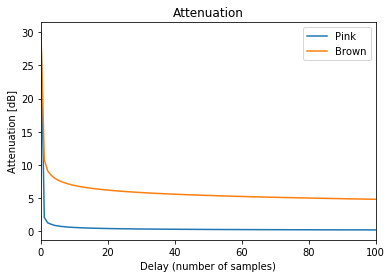

In [0]:
plt.plot(-10*np.log10(J_pink), label='Pink')
plt.plot(-10*np.log10(J_brown), label="Brown")
plt.title('Attenuation')
plt.xlim(0, 100)
plt.xlabel('Delay (number of samples)')
plt.ylabel('Attenuation [dB]')
plt.legend()
plt.show()